## Credit card applications

Commercial banks receive a lot of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays

For this project, we will build an automatic credit card approval predictor using machine learning techniques just like real banks do

We will use [Credit Card approval dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) from the UCI machine learning repository. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#ignores future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
#load datasets
cc_apps = pd.read_csv("crx.csv", names = ["Gender", "Age", "Debt", "Married", "BankCustomer", "EducationLevel", "Ethnicity", "YearsEmployed", "PriorDefault", "Employed", \
                                         "CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income", "ApprovalStatus"])

In [6]:
cc_apps.shape

(690, 16)

In [7]:
#inspect data
cc_apps.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [8]:
#check for na values
cc_apps.isna().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

In [9]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  ApprovalStatus  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [10]:
#summary stats
cc_apps.describe()

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


## Inspecting and cleaning data

In [11]:
cc_apps.dtypes

Gender             object
Age                object
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
ApprovalStatus     object
dtype: object

In [12]:
for c in cc_apps.loc[:, cc_apps.dtypes == np.object].drop(['Age', 'ZipCode'], axis = 1).columns:
    print("----{}----".format(c))
    print(cc_apps[c].value_counts())
    print("\n")

----Gender----
b    468
a    210
?     12
Name: Gender, dtype: int64


----Married----
u    519
y    163
?      6
l      2
Name: Married, dtype: int64


----BankCustomer----
g     519
p     163
?       6
gg      2
Name: BankCustomer, dtype: int64


----EducationLevel----
c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
x      38
m      38
d      30
e      25
j      10
?       9
r       3
Name: EducationLevel, dtype: int64


----Ethnicity----
v     399
h     138
bb     59
ff     57
?       9
z       8
j       8
dd      6
n       4
o       2
Name: Ethnicity, dtype: int64


----PriorDefault----
t    361
f    329
Name: PriorDefault, dtype: int64


----Employed----
f    395
t    295
Name: Employed, dtype: int64


----DriversLicense----
f    374
t    316
Name: DriversLicense, dtype: int64


----Citizen----
g    625
s     57
p      8
Name: Citizen, dtype: int64


----ApprovalStatus----
-    383
+    307
Name: ApprovalStatus, dtype: int64




#### We observe from the value_counts that some of the object columns have "?" as their values. We will deal with this by converting them to np.nan 

In [13]:
#Replace the '?' with Nan
cc_apps = cc_apps.replace({"--" : np.nan, '?' : np.nan})

#### Also, Age and Zipcode are of datatypes object but they should be numerical datatypes 

In [14]:
cc_apps['Age'] = cc_apps['Age'].astype('float')
cc_apps['ZipCode'] = cc_apps['ZipCode'].astype('float')

In [15]:
#filling missing values 
for col in cc_apps.columns:
    if cc_apps[col].dtype.name in ['int', 'float64']:
        cc_apps[col] = cc_apps[col].fillna(cc_apps[col].median())

#### We replaced the NA values in all of our numerical columns with thier median values

In [16]:
cc_apps['ZipCode'] = cc_apps['ZipCode'].astype('int').astype('category')

In [17]:
cc_apps['ZipCode'].value_counts().head()

0      132
160     47
120     35
200     35
80      30
Name: ZipCode, dtype: int64

In [18]:
cc_apps.isna().sum()

Gender            12
Age                0
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode            0
Income             0
ApprovalStatus     0
dtype: int64

In [19]:
cc_apps.dtypes

Gender              object
Age                float64
Debt               float64
Married             object
BankCustomer        object
EducationLevel      object
Ethnicity           object
YearsEmployed      float64
PriorDefault        object
Employed            object
CreditScore          int64
DriversLicense      object
Citizen             object
ZipCode           category
Income               int64
ApprovalStatus      object
dtype: object

#### We will convert then nan in the object columns with the most frequent values: 

In [20]:
for col in cc_apps.columns:
    if cc_apps[col].dtype.name == 'object':
        #impute with the most frequent value
        cc_apps[col] = cc_apps[col].fillna(cc_apps[col].value_counts().idxmax())

#### check again for missing value

In [21]:
cc_apps.isna().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

#### check if the ? in the missing value is now updated to the most frequent value

In [22]:
for c in cc_apps.loc[:, cc_apps.dtypes == np.object].columns:
    print("----{}----".format(c))
    print(cc_apps[c].value_counts())
    print("\n")

----Gender----
b    480
a    210
Name: Gender, dtype: int64


----Married----
u    525
y    163
l      2
Name: Married, dtype: int64


----BankCustomer----
g     525
p     163
gg      2
Name: BankCustomer, dtype: int64


----EducationLevel----
c     146
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
x      38
m      38
d      30
e      25
j      10
r       3
Name: EducationLevel, dtype: int64


----Ethnicity----
v     408
h     138
bb     59
ff     57
z       8
j       8
dd      6
n       4
o       2
Name: Ethnicity, dtype: int64


----PriorDefault----
t    361
f    329
Name: PriorDefault, dtype: int64


----Employed----
f    395
t    295
Name: Employed, dtype: int64


----DriversLicense----
f    374
t    316
Name: DriversLicense, dtype: int64


----Citizen----
g    625
s     57
p      8
Name: Citizen, dtype: int64


----ApprovalStatus----
-    383
+    307
Name: ApprovalStatus, dtype: int64




#### Check for any duplicated values:

In [23]:
print(cc_apps[cc_apps.duplicated() == True])

Empty DataFrame
Columns: [Gender, Age, Debt, Married, BankCustomer, EducationLevel, Ethnicity, YearsEmployed, PriorDefault, Employed, CreditScore, DriversLicense, Citizen, ZipCode, Income, ApprovalStatus]
Index: []


#### There are no duplicated rows in this dataset

In [24]:
cc_apps['ApprovalStatus'].value_counts()

-    383
+    307
Name: ApprovalStatus, dtype: int64

#### Since this dataset is confidential, some of the column values was changed. To help make sense of the data, I will be making general changes to some of the column values in order to help with exploratory data analysis. 
#### First, conversion of some of the values in our independent columns. The gender will be changed from b and a to male and female. The PriorDefault, Employed, and DriversLicense columns will be changed from t and f to yes and no. We will convert BankCustomer column from the values g, p, gg to yes, no, unknown. Also, the values for married column will be converted from u, y, l to  married, unmarried, unknown 

In [25]:
cc_apps[['Employed', 'DriversLicense']] = cc_apps[['Employed', 'DriversLicense']].replace({'f': 'no', 't': 'yes'})

In [26]:
cc_apps['PriorDefault'] = cc_apps['PriorDefault'].replace({'yes' : 'no', 'no' : 'yes'})

In [27]:
cc_apps['BankCustomer'] = cc_apps['BankCustomer'].replace({'g': 'yes', 'p' : 'no', 'gg' : 'unknown'})

In [28]:
cc_apps['Married'] = cc_apps['Married'].replace({'u': 'married', 'y' : 'single', 'l' : 'unknown'})

#### Conversion of the values in our dependent variable *ApprovalStatus* from + and - to 1 and 0 respectively:

In [29]:
cc_apps['ApprovalStatus'] = cc_apps['ApprovalStatus'].replace({'+': 1, '-': 0})

#### 1 means they were approved a credit card. 0 means they werent approved

## Exploratory data visualization

In [30]:
cc_apps.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,married,yes,w,v,1.25,t,yes,1,no,g,202,0,1
1,a,58.67,4.460,married,yes,q,h,3.04,t,yes,6,no,g,43,560,1
2,a,24.50,0.500,married,yes,q,h,1.50,t,no,0,no,g,280,824,1
3,b,27.83,1.540,married,yes,w,v,3.75,t,yes,5,yes,g,100,3,1
4,b,20.17,5.625,married,yes,w,v,1.71,t,no,0,no,s,120,0,1


#### How many people were approved and how many werent?:

In [31]:
sns.set_style('whitegrid')

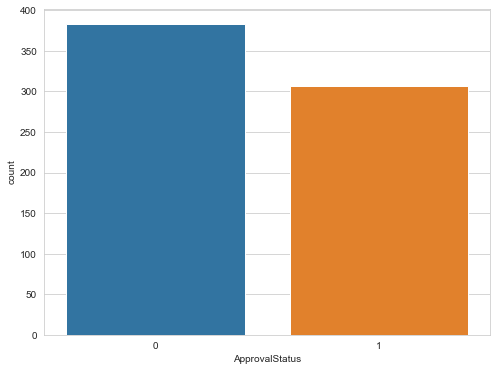

In [32]:
plt.figure(figsize = (8, 6))
sns.countplot(cc_apps['ApprovalStatus'])

#### From the figure above, just over 380 people got denied a credit card and 307 got approved of a credit card

#### How is the age distribution of the participants in this data?

Text(0, 0.5, 'Frequency')

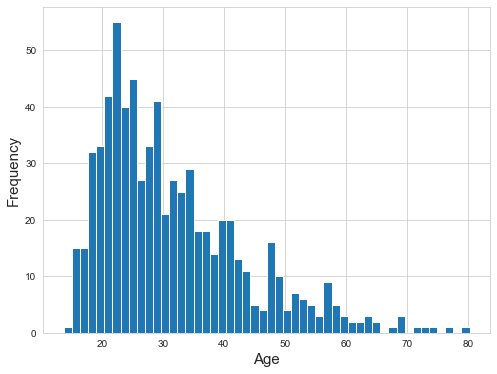

In [33]:
plt.figure(figsize = (8, 6))
cc_apps['Age'].plot(kind = 'hist', bins = 50)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [34]:
print(cc_apps['Age'].max())
cc_apps['Age'].min()

80.25


13.75

#### Create an Age_group column from the Age column to help understand the data

In [35]:
age_group = ['13-25', '25-50', '50+']
#creates age groups 
cc_apps['Age_group'] = pd.qcut(cc_apps['Age'], q = 3, labels = age_group)

Text(0.5, 0, 'Age_group')

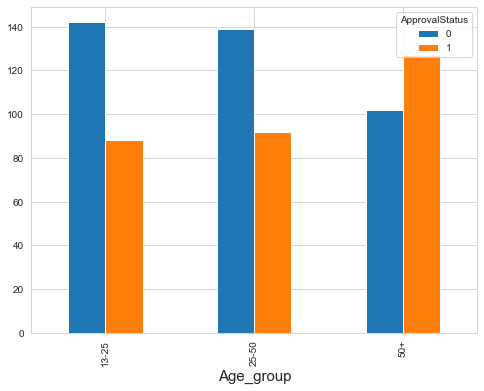

In [36]:
pd.pivot_table(data = cc_apps, index = ['Age_group'], columns = 'ApprovalStatus', aggfunc='size', fill_value=0).plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Age_group', fontsize = 15)
#cc_apps.groupby(['Age_group', 'ApprovalStatus'])['ApprovalStatus'].count().unstack('ApprovalStatus').plot(kind = 'bar')

#### From the figure above, majority of the individuals that applied for credit card are within the age group 13-25 and 25-50. More people above 50 got approved of a credit card. 

#### How does current job employment affect credit card approval?

Text(0.5, 0, 'Employed')

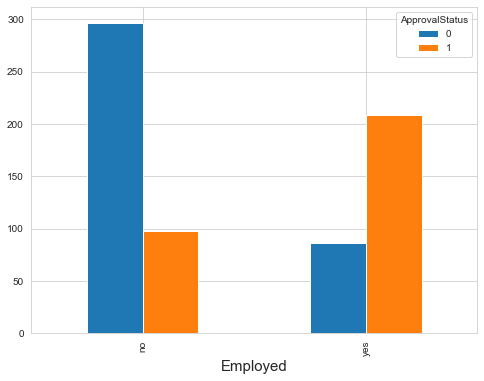

In [37]:
cc_apps.groupby(['Employed', 'ApprovalStatus'])['ApprovalStatus'].count().unstack('ApprovalStatus').fillna(0).plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Employed', fontsize = 15)

#### From the figure above, majority of the indidual who got approved of a credit card were employed or had a job 

#### How does Credit score and Income affect credit card approval?

Text(35.377170138888886, 0.5, 'Income')

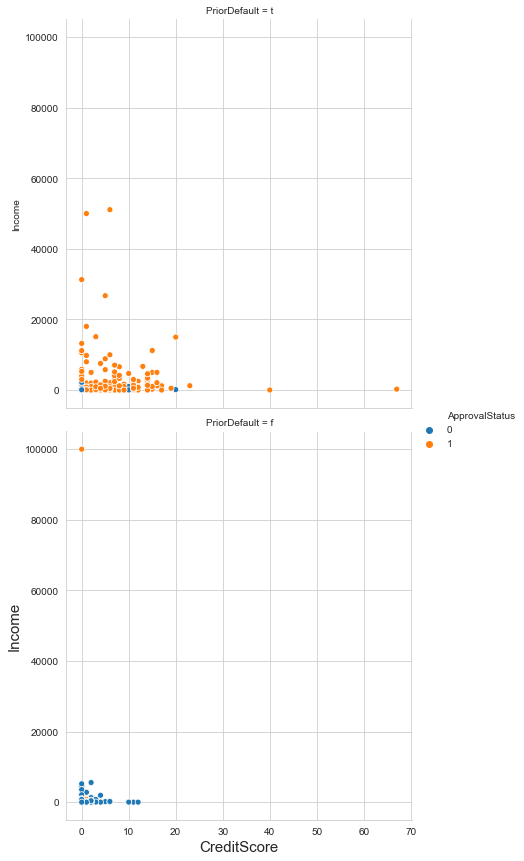

In [38]:
sns.relplot(x='CreditScore', y = 'Income', hue = 'ApprovalStatus',  data = cc_apps, height = 6, aspect = 1, row = 'PriorDefault')
plt.xlabel('CreditScore', fontsize = 15)
plt.ylabel('Income', fontsize = 15)

#### From the figure above, we deduce that individuals with high income and/or high credit score are likely to be approved to a credit card. However, the most important feature that separates the dependendent variable - ApprovalStatus is PriorDefault. The figure shows that most people with PriorDefault are denied a credit card. 

## Data Preprocessing

#### 1. Convert the non-mumeric data into numeric

In [39]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Gender          690 non-null    object  
 1   Age             690 non-null    float64 
 2   Debt            690 non-null    float64 
 3   Married         690 non-null    object  
 4   BankCustomer    690 non-null    object  
 5   EducationLevel  690 non-null    object  
 6   Ethnicity       690 non-null    object  
 7   YearsEmployed   690 non-null    float64 
 8   PriorDefault    690 non-null    object  
 9   Employed        690 non-null    object  
 10  CreditScore     690 non-null    int64   
 11  DriversLicense  690 non-null    object  
 12  Citizen         690 non-null    object  
 13  ZipCode         690 non-null    category
 14  Income          690 non-null    int64   
 15  ApprovalStatus  690 non-null    int64   
 16  Age_group       690 non-null    category
dtypes: category(2), 

#### Here, we will use pd.get_dummies to convert all of our categorical columns into numeric columns. We could also use OneHotEncoder from Sklearn.preprocessing

In [40]:
cc_apps_new_df = pd.get_dummies(data = cc_apps, columns = ['Gender', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'PriorDefault', 'Employed', 'Citizen', 'DriversLicense', 'Age_group'], drop_first = True )

In [41]:
cc_apps_new_df.head()

,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income,ApprovalStatus,Gender_b,Married_single,Married_unknown,...,Ethnicity_o,Ethnicity_v,Ethnicity_z,PriorDefault_t,Employed_yes,Citizen_p,Citizen_s,DriversLicense_yes,Age_group_25-50,Age_group_50+
0,30.83,0.000,1.25,1,202,0,1,1,0,0,...,0,1,0,1,1,0,0,0,1,0
1,58.67,4.460,3.04,6,43,560,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,24.50,0.500,1.50,0,280,824,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,27.83,1.540,3.75,5,100,3,1,1,0,0,...,0,1,0,1,1,0,0,1,1,0
4,20.17,5.625,1.71,0,120,0,1,1,0,0,...,0,1,0,1,0,0,1,0,0,0


In [42]:
cc_apps_new_df.columns

Index(['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'ZipCode', 'Income',
       'ApprovalStatus', 'Gender_b', 'Married_single', 'Married_unknown',
       'BankCustomer_unknown', 'BankCustomer_yes', 'EducationLevel_c',
       'EducationLevel_cc', 'EducationLevel_d', 'EducationLevel_e',
       'EducationLevel_ff', 'EducationLevel_i', 'EducationLevel_j',
       'EducationLevel_k', 'EducationLevel_m', 'EducationLevel_q',
       'EducationLevel_r', 'EducationLevel_w', 'EducationLevel_x',
       'Ethnicity_dd', 'Ethnicity_ff', 'Ethnicity_h', 'Ethnicity_j',
       'Ethnicity_n', 'Ethnicity_o', 'Ethnicity_v', 'Ethnicity_z',
       'PriorDefault_t', 'Employed_yes', 'Citizen_p', 'Citizen_s',
       'DriversLicense_yes', 'Age_group_25-50', 'Age_group_50+'],
      dtype='object')

In [43]:
cc_apps_new_df = cc_apps_new_df.drop('ZipCode', axis = 1)

## Split Data into training and test sets

<br />

***Data Split 1: Final Data, no scaling***

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X = cc_apps_new_df.drop('ApprovalStatus', axis = 'columns')

In [46]:
y = cc_apps_new_df['ApprovalStatus']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, stratify = y, random_state = 42)

<br />

***Data Split 2: Final Data, with scaling***

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scalar = MinMaxScaler(feature_range=(0,1))

In [50]:
X_scaled = scalar.fit_transform(X)

In [51]:
X_scaled.shape

(690, 38)

In [52]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y, test_size = 0.3, shuffle = True, stratify = y, random_state = 42)

## Fitting models to the training data

### 1. Logistic Regression

#### Since our dependent variable is caterogical, we will start with Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

***Model Training***

In [54]:
# run block of code and catch warnings
with warnings.catch_warnings():
	# ignore all caught warnings
	warnings.filterwarnings("ignore")

In [59]:
#Instantiate Logistic Regression Classifier with default parameters
logreg1 = LogisticRegression(max_iter = 10000)
logreg1.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [60]:
logreg1

LogisticRegression(max_iter=10000)

In [61]:
logreg2 = LogisticRegression(max_iter = 10000)
logreg2.fit(X2_train, y2_train)

LogisticRegression(max_iter=10000)

***Predictions***

In [62]:
y_pred = logreg1.predict(X_test)
y2_pred = logreg2.predict(X2_test)

***Evaluation***

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [64]:
print("Logistic Regression Performance: \n")
print("No scaling of the Independent variables")
print("Accuracy of traning set: ", logreg1.score(X_train, y_train))
print('Accuracy of test set', logreg1.score(X_test, y_test))
print("Confusion matrix: \n",confusion_matrix(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

Logistic Regression Performance: 

No scaling of the Independent variables
Accuracy of traning set:  0.865424430641822
Accuracy of test set 0.9033816425120773
Confusion matrix: 
 [[103  12]
 [  8  84]]
Precision:  0.875
Recall:  0.9130434782608695
F1 score:  0.8936170212765957


Text(0.5, 257.44, 'Predicted label')

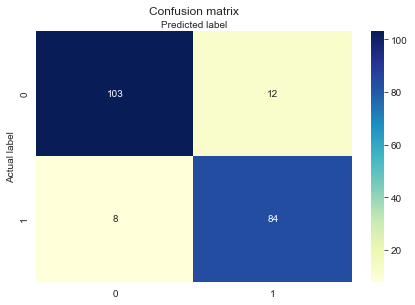

In [65]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [66]:
print("Scaling of the Independent variables\n")
print("Accuracy of scaled traning set: ", logreg2.score(X2_train, y2_train))
print('Accuracy of scaled test set', logreg2.score(X2_test, y2_test))
print("Confusion matrix for scaled data: \n",confusion_matrix(y2_test, y2_pred))
print("Precision of scaled data: ", precision_score(y2_test, y2_pred))
print("Recall of scaled data: ", recall_score(y2_test, y2_pred))
print("F1 score of scaled data: ", f1_score(y2_test, y2_pred))

Scaling of the Independent variables

Accuracy of scaled traning set:  0.8592132505175983
Accuracy of scaled test set 0.8840579710144928
Confusion matrix for scaled data: 
 [[99 16]
 [ 8 84]]
Precision of scaled data:  0.84
Recall of scaled data:  0.9130434782608695
F1 score of scaled data:  0.8749999999999999


#### From the metrics above, the accuracy of our test set is higher than the accuracy of our traning set for both Scaled and Unscaled data. Also, the number of False positive and False negative are nearly similar for the unscaled and scaled test set. 

### Hyperparameter tuning

#### We will select set of optimal hyperparameters to improve the accuracy of our Logistic regression algorithm for the unscaled data

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [69]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=logreg1,
                    param_grid=param_grid,
                    scoring = 'accuracy',
                    cv = 5,
                    verbose=1, 
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('Best Estimator: ', grid_result.best_estimator_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min


Best Score:  0.859192439862543
Best Params:  {'C': 1, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l1', 'solver': 'liblinear'}
Best Estimator:  LogisticRegression(C=1, class_weight={0: 0.6, 1: 0.4}, max_iter=10000,
                   penalty='l1', solver='liblinear')


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.8min finished


 #### The use of hyperparameter tuning does not significantly improve our Logistic regression algorithm

#### ROC Curve

#### Receiver operating characteristics (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

In [70]:
print("roc_auc_score", roc_auc_score(y_test, y_pred))

roc_auc_score 0.9043478260869565


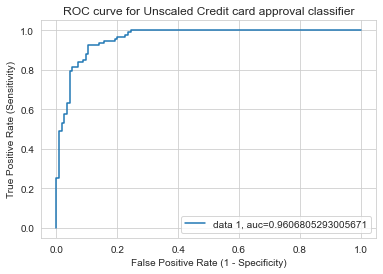

In [71]:
y_pred_proba = logreg1.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc =roc_auc_score(y_test, y_pred_proba)
plt.title('ROC curve for Unscaled Credit card approval classifier')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc=4)
plt.show()

In [72]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [73]:
evaluate_threshold(0.4)

Sensitivity: 0.9347826086956522
Specificity: 0.8608695652173913


In [74]:
evaluate_threshold(0.5)

Sensitivity: 0.8804347826086957
Specificity: 0.8956521739130435


#### For this data, the best threshold that balances sensitivity and specificity for the unscaled test data is between 0.4 and 0.5

### 2. Support Vector Classifier(SVC)

In [75]:
from sklearn.svm import SVC

***Model Training***

In [76]:
#Instantiate with default hyperparameters
svc1 = SVC()
svc1.fit(X_train, y_train)

SVC()

In [77]:
svc2 = SVC()
svc2.fit(X2_train, y2_train)

SVC()

<br />

***Predictions***

In [78]:
svc1_y_pred = svc1.predict(X_test)
svc2_y_pred = svc2.predict(X2_test)

<br />

***Evaluation***

In [79]:
print("SVC Performance: \n")
print("No scaling of the Independent variables")
print("Accuracy of traning set: ", svc1.score(X_train, y_train))
print('Accuracy of test set', svc1.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, svc1_y_pred))
print("Precision: ", precision_score(y_test, svc1_y_pred))
print("Recall: ", recall_score(y_test, svc1_y_pred))
print("F1 score: ", f1_score(y_test, svc1_y_pred))

SVC Performance: 

No scaling of the Independent variables
Accuracy of traning set:  0.6459627329192547
Accuracy of test set 0.6666666666666666
Confusion matrix: 
 [[106   9]
 [ 60  32]]
Precision:  0.7804878048780488
Recall:  0.34782608695652173
F1 score:  0.481203007518797


#### The SVC model does not perform well for the unscaled data compared to Logistic Regression    

In [80]:
print("Scaling of the Independent variables\n")
print("Accuracy of scaled traning set: ", svc2.score(X2_train, y2_train))
print('Accuracy of scaled test set', svc2.score(X2_test, y2_test))
print("Confusion matrix for scaled data: \n",confusion_matrix(y2_test, svc2_y_pred))
print("Precision of scaled data: ", precision_score(y2_test, svc2_y_pred))
print("Recall of scaled data: ", recall_score(y2_test, svc2_y_pred))
print("F1 score of scaled data: ", f1_score(y2_test, svc2_y_pred))

Scaling of the Independent variables

Accuracy of scaled traning set:  0.8964803312629399
Accuracy of scaled test set 0.8888888888888888
Confusion matrix for scaled data: 
 [[102  13]
 [ 10  82]]
Precision of scaled data:  0.8631578947368421
Recall of scaled data:  0.8913043478260869
F1 score of scaled data:  0.8770053475935828


#### The SVC model performs better on the scaled data compared to the unscaled data. Also, the accuracy of the training and test data are nearly similar. 

### Hyperparameter Tuning

#### Here, we will use RandomizedSearchCV to find near-optimal hyperparameters to improve the accuracy of our Support Vector Classifier (SVC) model

In [81]:
from sklearn.model_selection import RandomizedSearchCV

In [85]:
kernel = ['poly', 'rbf', 'linear', 'sigmoid']
C = [100, 10, 1.0, 0.01]
gamma = ['scale']

param_grid = dict(kernel = kernel,
                  C=C,
                  gamma = gamma)

grid_svm_1 = RandomizedSearchCV(estimator=svc1,
                    param_distributions=param_grid,
                    scoring = 'accuracy',
                    cv = 5,
                    verbose=1, 
                    n_jobs=-1)

grid_result_svm1 = grid_svm_1.fit(X_train, y_train)
print("Hyper-parameter tuning for unscaled data: ")
print('Best Score: ', grid_result_svm1.best_score_)
print('Best Params: ', grid_result_svm1.best_params_)
print('Best Estimator: ', grid_result_svm1.best_estimator_)

grid_svm_2 = RandomizedSearchCV(estimator=svc2,
                    param_distributions=param_grid,
                    scoring = 'accuracy',
                    cv = 5,
                    verbose=1, 
                    n_jobs=-1)

grid_result_svm2 = grid_svm_2.fit(X2_train, y2_train)
print("Hyper-parameter tuning for Scaled data: ")
print('Best Score: ', grid_result_svm2.best_score_)
print('Best Params: ', grid_result_svm2.best_params_)
print('Best Estimator: ', grid_result_svm2.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.7min finished


Hyper-parameter tuning for unscaled data: 
Best Score:  0.8073883161512028
Best Params:  {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best Estimator:  SVC(C=10, kernel='linear')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Hyper-parameter tuning for Scaled data: 
Best Score:  0.8468213058419243
Best Params:  {'kernel': 'poly', 'gamma': 'scale', 'C': 1.0}
Best Estimator:  SVC(kernel='poly')


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


#### Hyperparameter tuning improves the accuracy of the unscaled data but the accuracy of the scaled data is nearly similar to the default hyperparameters

In [ ]:
svc_hp_1 = SVC(C=10, kernel='linear')
svc_hp_1.fit(X_train, y_train)

In [90]:
print("Following hyperparameter tuning of unscaled data: ")
print("Accuracy: ", svc_hp_1.score(X_test, y_test))

Following hyperparameter tuning of unscaled data: 
Accuracy:  0.855072463768116




### 3. K Nearest neighbor

#### We will build a KNN model to our scaled data since scaling improves the performance of KNN algorithm 

***Model training***

In [116]:
#using default hyperparameters to train scaled data 

knn = KNeighborsClassifier()
knn.fit(X2_train, y2_train)

KNeighborsClassifier()

***Predictions***

In [216]:
knn_y_pred = knn.predict(X2_test)

<br />

***Model Evaluation***


In [217]:
print("KNN model performance: \n")
print("Scaled independent features")
print("Accuracy of traning set: ", knn.score(X2_train, y2_train))
print('Accuracy of test set', knn.score(X2_test, y2_test))
print("Confusion matrix: \n", confusion_matrix(y2_test, knn_y_pred))
print("Precision: ", precision_score(y2_test, knn_y_pred))
print("Recall: ", recall_score(y2_test, knn_y_pred))
print("F1 score: ", f1_score(y2_test, knn_y_pred))

KNN model performance: 

Scaled independent features
Accuracy of traning set:  0.8778467908902692
Accuracy of test set 0.8599033816425121
Confusion matrix: 
 [[100  15]
 [ 14  78]]
Precision:  0.8387096774193549
Recall:  0.8478260869565217
F1 score:  0.8432432432432434


#### The accuracy of the KNN classifier model is consistent accross the training and test set. The default number of neighbor used by KNN classifier is 5. We will try and search for optimal value of K for our KNN classfier.

In [218]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X2_train, y2_train, scoring='accuracy')
    k_scores.append(scores.mean())

Text(0, 0.5, 'Cross-Validated Accuracy')

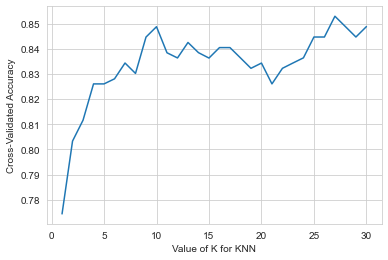

In [219]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#### We will try n_neighbors=9 to see if it improves the accuracy of our predictions.  

In [129]:
knn_2 = KNeighborsClassifier(n_neighbors=9)
knn_2.fit(X2_train, y2_train)
knn_2.score(X2_test, y2_test)

0.8647342995169082

In [220]:
y_pred_knn2 = knn_2.predict(X2_test)

In [221]:
print("KNN model performance after finding highest K value: \n")
print("Scaled independent features")
print("Accuracy of traning set: ", knn_2.score(X2_train, y2_train))
print('Accuracy of test set', knn_2.score(X2_test, y2_test))
print("Confusion matrix: \n", confusion_matrix(y2_test, y_pred_knn2))
print("Precision: ", precision_score(y2_test, y_pred_knn2))
print("Recall: ", recall_score(y2_test, y_pred_knn2))
print("F1 score: ", f1_score(y2_test, y_pred_knn2))

KNN model performance after finding highest K value: 

Scaled independent features
Accuracy of traning set:  0.8633540372670807
Accuracy of test set 0.8647342995169082
Confusion matrix: 
 [[103  12]
 [ 16  76]]
Precision:  0.8636363636363636
Recall:  0.8260869565217391
F1 score:  0.8444444444444444


#### It does improve the accuracy of our model by a small margin. 
#### We can also use GridSearchCV or RandomizedSearchCV to select optimal hyperparameters to increase our K score. 

<br />

### 4.Decision Tree

#### We will only use our unscaled data for this machine learning model. DT rely on rules and it isnt affected by transformation of the features. 

In [130]:
from sklearn.tree import DecisionTreeClassifier

<b />

***Model training***

In [135]:
#Instatiate decisiontree classifier
dt = DecisionTreeClassifier()
#fit model to training data
dt.fit(X_train, y_train)

DecisionTreeClassifier()

<br />

***Predictions***

In [136]:
y_pred_dt = dt.predict(X_test)

<b />

***Model Evaluation***

In [138]:
print("DecisionTree performance: \n")
print("Unscaled independent features")
print("Accuracy of traning set: ", dt.score(X_train, y_train))
print('Accuracy of test set', dt.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
print("F1 score: ", f1_score(y_test, y_pred_dt))

DecisionTree performance: 

Unscaled independent features
Accuracy of traning set:  1.0
Accuracy of test set 0.8502415458937198
Confusion matrix: 
 [[99 16]
 [15 77]]
Precision:  0.8279569892473119
Recall:  0.8369565217391305
F1 score:  0.8324324324324325


#### From the result above, we observe that decisiontree model overfits the training data (low bias and high variance). 

#### Lets see if we can improve test accuracy by hyperparameter tuning. We can set a maxdepth of 5 for our model such that no nodes are created right after the max depth. We can also adjust the min_samples_leaf to 0.2

In [143]:
dt_2 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=0.4)
dt_2.fit(X_train, y_train)
y_pred_dt2 = dt_2.predict(X_test)
print("DecisionTree performance following Hyperparameter tuning: \n")
print("Unscaled independent features")
print("Accuracy of traning set: ", dt_2.score(X_train, y_train))
print('Accuracy of test set', dt_2.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_dt2))
print("Precision: ", precision_score(y_test, y_pred_dt2))
print("Recall: ", recall_score(y_test, y_pred_dt2))
print("F1 score: ", f1_score(y_test, y_pred_dt2))

DecisionTree performance following Hyperparameter tuning: 

Unscaled independent features
Accuracy of traning set:  0.8302277432712215
Accuracy of test set 0.9130434782608695
Confusion matrix: 
 [[98 17]
 [ 1 91]]
Precision:  0.8425925925925926
Recall:  0.9891304347826086
F1 score:  0.91


#### By setting a max_depth and changing the min_samples_leaf, we notice an underfitting of the model to the training data but perfomed well on the test data. 

#### In an attempt to reduce overfitting, we did underfit the model to the training data. However, the training accuracy score is consistent with other classification models that we looked at, but we got a higher test accuracy

## Ensemble learning

#### It is much reliable to use various models rather than just one. A collection of several models working together on a single data is called ```Ensemble```

### 5. Voting Classifier

In [144]:
from sklearn.ensemble import VotingClassifier

<b />

***Model building and prediction on unscaled data***

In [154]:
voting_clf_1 = VotingClassifier([('Logistic Regression', logreg1), ('K Nearest neighbors', knn), ('SVC', svc1), ('Decision Tree', dt_2)])
voting_clf_1.fit(X_train, y_train)
y_pred_vt_1 = voting_clf_1.predict(X_test)
print('Voting Classifier score: {}'.format(voting_clf_1.score(X_test, y_test)))

Voting Classifier score: 0.821256038647343


***Model building and prediction on scaled data***

In [164]:
voting_clf_2 = VotingClassifier([('Logistic Regression', logreg1), ('K Nearest neighbors', knn), ('SVC', svc1), ('Decision Tree', dt_2)])
voting_clf_2.fit(X2_train, y2_train)
y_pred_vt_2 = voting_clf.predict(X2_test)
print('Voting Classifier score: {}'.format(voting_clf_2.score(X2_test, y2_test)))

Voting Classifier score: 0.8888888888888888


***Evaluation of unscaled data***

In [215]:
print("VotingClassifier performance: \n")
print("Unscaled independent features")
print("Accuracy of traning set: ", voting_clf_1.score(X_train, y_train))
print('Accuracy of test set', voting_clf_1.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_vt_1))
print("Precision: ", precision_score(y_test, y_pred_vt_1))
print("Recall: ", recall_score(y_test, y_pred_vt_1))
print("F1 score: ", f1_score(y_test, y_pred_vt_1))

VotingClassifier performance: 

Unscaled independent features
Accuracy of traning set:  0.8157349896480331
Accuracy of test set 0.821256038647343
Confusion matrix: 
 [[112   3]
 [ 34  58]]
Precision:  0.9508196721311475
Recall:  0.6304347826086957
F1 score:  0.758169934640523


***Evaluation of scaled data***

In [165]:
print("VotingClassifier performance: \n")
print("Scaled independent features")
print("Accuracy of traning set: ", voting_clf_2.score(X2_train, y2_train))
print('Accuracy of test set', voting_clf_2.score(X2_test, y2_test))
print("Confusion matrix: \n", confusion_matrix(y2_test, y_pred_vt_2))
print("Precision: ", precision_score(y2_test, y_pred_vt_2))
print("Recall: ", recall_score(y2_test, y_pred_vt_2))
print("F1 score: ", f1_score(y2_test, y_pred_vt_2))

VotingClassifier performance: 

Scaled independent features
Accuracy of traning set:  0.8778467908902692
Accuracy of test set 0.8888888888888888
Confusion matrix: 
 [[102  13]
 [ 10  82]]
Precision:  0.8631578947368421
Recall:  0.8913043478260869
F1 score:  0.8770053475935828


#### From the above run, the voting classifier accuracy score for the scaled test set is higher than the unscaled test set data. 

### 6. Random Forest 

In [166]:
from sklearn.ensemble import RandomForestClassifier

#### With Random forest, we will get to know the important features that help to classify our dependent variable

***Model building***

In [170]:
RF = RandomForestClassifier(oob_score=True)
RF.fit(X_train, y_train) #fitting model to unscaled data

RandomForestClassifier(oob_score=True)

***Model prediction***

In [171]:
y_pred_RF = RF.predict(X_test)

***Model Evaluation***

In [176]:
print('OOB accuracy: {:.3F}'.format(RF.oob_score_))

OOB accuracy: 0.843


In [177]:
print("RandomForest performance: \n")
print("Unscaled independent features")
print("Accuracy of traning set: ", RF.score(X_train, y_train))
print('Accuracy of test set', RF.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_RF))
print("Precision: ", precision_score(y_test, y_pred_RF))
print("Recall: ", recall_score(y_test, y_pred_RF))
print("F1 score: ", f1_score(y_test, y_pred_RF))

RandomForest performance: 

Unscaled independent features
Accuracy of traning set:  1.0
Accuracy of test set 0.893719806763285
Confusion matrix: 
 [[109   6]
 [ 16  76]]
Precision:  0.926829268292683
Recall:  0.8260869565217391
F1 score:  0.8735632183908046


#### From the Random Forest evalation, the ensemble model fit perfectly to the training data (i.e high bias) but high variance to the test data. 

#### We will try and find the important features directly influencing our Random Forest model

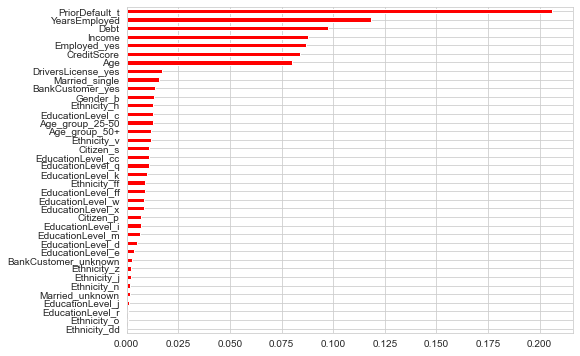

In [214]:
important_rf = pd.Series(RF.feature_importances_, index = X.columns)
sorted_important_rf = important_rf.sort_values()
sorted_important_rf.plot(kind = 'barh', color = 'red', figsize = (8, 6))
plt.show()

#### Just as we obseved in the Exploratory data analysis section, the most important features responsible for separating those who got approved of a credit card and those who didnt is Prior Default. 

#### We will try To reduce variance to the test data using hyperparameter tuning

***Model Building and prediction***

In [203]:
 params_dt_rf = {
     'max_depth' : [3, 4, 5, 6], 
     'min_samples_leaf' : [0.04, 0.06, 0.08], 
     'max_features' : [0.2, 0.4, 0.6, 0.8]
 }

In [204]:
RF_grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(), 
                         param_grid = params_dt_rf, 
                         cv = 10, n_jobs=-1)

In [205]:
RF_grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]})

***Evaluation***

In [206]:
print('Best hyperparameter for RandomForestClassifier: {}'.format(RF_grid_dt.best_params_))

Best hyperparameter for RandomForestClassifier: {'max_depth': 3, 'max_features': 0.6, 'min_samples_leaf': 0.04}


In [207]:
print('Best cv score: {}'.format(RF_grid_dt.best_score_))

Best cv score: 0.8387755102040817


In [210]:
#extract RF best model and predict
RF_best_model = RF_grid_dt.best_estimator_
y_pred_RFdt = RF_best_model.predict(X_test)

In [211]:
print("RandomForest performance following hyperparameter tuning: \n")
print("Unscaled independent features")
print("Accuracy of traning set: ", RF_best_model.score(X_train, y_train))
print('Accuracy of test set', RF_best_model.score(X_test, y_test))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_RFdt))
print("Precision: ", precision_score(y_test, y_pred_RFdt))
print("Recall: ", recall_score(y_test, y_pred_RFdt))
print("F1 score: ", f1_score(y_test, y_pred_RFdt))

RandomForest performance following hyperparameter tuning: 

Unscaled independent features
Accuracy of traning set:  0.855072463768116
Accuracy of test set 0.8599033816425121
Confusion matrix: 
 [[108   7]
 [ 22  70]]
Precision:  0.9090909090909091
Recall:  0.7608695652173914
F1 score:  0.8284023668639053


#### Hyperparametuning reduced variance but consequently increased bias of the best model (obtained via grid search) to the training data 

## Conclusion

#### In this project, we used applicant information dataset to build credit card approval predictor. Four base machine learning model was used for this project (Logistic regression, support vector classifier, K-Nearest neighbors, Decision tree). We also used 2 ensemble learning model (Voting Classifier and Random Forest). We achieved the best prediction performance using Logistic regression on unscaled data. 

#### Based on the confusion matrix, the Logistic regression model on unscaled data gave the least number of false positive (12) and false negative (8).

#### However, the KNN model on unscaled data resulted in similar accuracy score on both training and test data. 

#### By doing exploratory data visualization and Random Forest classifier, the feature highly responsible for credit card approval is Prior_Default. Most of the customers with prior default were not approved a credit and vice versa. 

## Future Work

#### Reduce error (FP and FN) by trying different boosting techniqes such as AdaBoost, Gradient Boost and XGBoost. 